# Visualizing Catalytic Potentials of Glycolytic Regulatory Kinases

This notebook provides two examples on creating more sophisticated figures using MASSpy. Specifically, the two examples will reproduce the following from the publication by <cite data-cite="YAHP18">Yurkovich et al., 2018</cite>
- Example **A**: Reproduce Figure 2 of main text.
- Example **B**: Reproduce Figure 4 of main text.


In [1]:
from os import path

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from mass import Simulation
from mass.example_data import create_example_model
from mass.util import strip_time
from mass.visualization import plot_phase_portrait, plot_time_profile

All models for this example have already been constructed based on <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> and can be found [here](https://github.com/SBRG/MASSpy-ExampleProject).

## Example A: Phase Portraits of Catalytic Potentials for Individual Enzymes
In this example, the three key regulatory kinases of glycolysis are integrated into the glycolytic network as enzyme modules.

Specifically, this notebook example focuses on visualizing the catalytic potential of each individual enzyme when only one enzyme module are integrated into the network in order to reproduce [Figure 2](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g002) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite>

### A1: All in one
The following cell reproduces [Figure 2](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g002) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite>

Successfully loaded MassModel 'Glycolysis_Hb_PFK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_PYK' into RoadRunner.


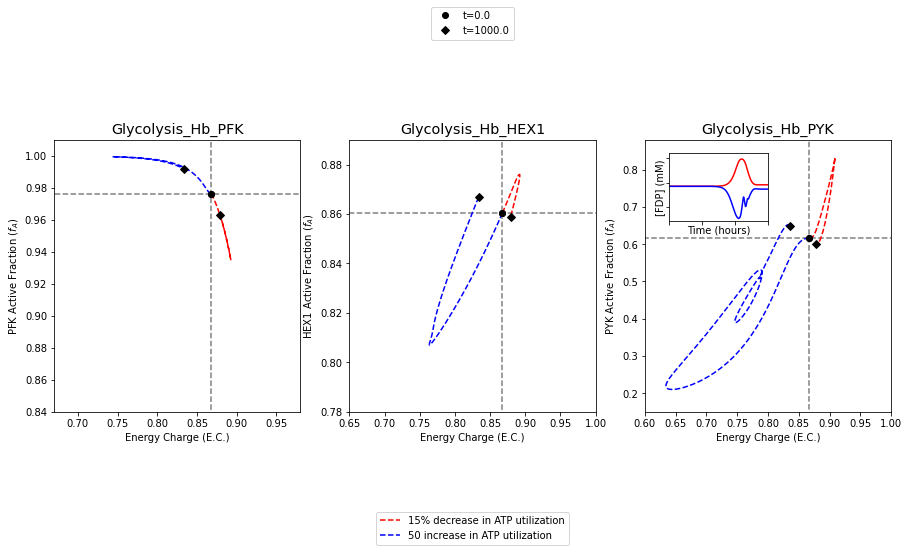

In [2]:
# Create list of model IDs
model_ids = ["Glycolysis_Hb_PFK",
             "Glycolysis_Hb_HEX1",
             "Glycolysis_Hb_PYK"]
# Define perturbations
perturbations = [
    {"kf_ATPM": "kf_ATPM * 0.85"},
    {"kf_ATPM": "kf_ATPM * 1.50"}]
# Define colors and legend labels
colors = ["red", "blue"]
labels = ["15% decrease", "50 increase"]

# Define axes limits
xy_limits = { 
    "PFK":  [(0.67, 0.98), (0.84, 1.01)],
    "HEX1": [(0.65, 1.00), (0.78, 0.89)],
    "PYK":  [(0.60, 1.00), (0.15, 0.88)]}

# Define helper functions to make aggregate solutions
def make_energy_charge_solution(conc_sol):
    conc_sol.make_aggregate_solution(
        aggregate_id="energy_charge",
        equation="(atp_c + 0.5 * adp_c) / (atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)
    
def make_active_fraction_solution(model, conc_sol, enzyme):
    enzyme = model.enzyme_modules.get_by_id(enzyme)
    active = enzyme.enzyme_module_forms_categorized.get_by_id(
        enzyme.id + "_Active")
    conc_sol.make_aggregate_solution(
        aggregate_id="active_fraction",
        equation="({0}) / ({1})".format(
            " + ".join([e.id for e in active.members]),
             str(strip_time(enzyme.enzyme_concentration_total_equation))),
        variables=enzyme.enzyme_module_forms, update=True)

# Create figure and flatten axes into a list
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flatten()
# Create inset axes
ax_inset = axes[-1].inset_axes([0.1, 0.7, 0.4, 0.25])
ax_inset.tick_params(labelbottom=False, labelleft=False)

# Iterate through models and axes instances
for i, (model_id, ax) in enumerate(zip(model_ids, axes)):
    # Load model and simulation
    model = create_example_model(model_id + ".json")
    sim = Simulation(model, verbose=True)
    
    # Get ID of enzyme module in model
    enzyme_id = model.id.split("_")[-1]
    
    # Ensure models are in steady state and make aggregate solutions
    conc_sol, flux_sol = sim.find_steady_state(
        model, strategy="simulate", update_values=True, tfinal=1e4)
    make_energy_charge_solution(conc_sol)
    make_active_fraction_solution(model, conc_sol, enzyme_id)
    
    # Plot steady state lines
    ax.plot([conc_sol["energy_charge"]] * 2, [-0.1, 1.1],
            color="grey", linestyle="--")
    ax.plot([-0.1, 1.1], [conc_sol["active_fraction"]] * 2,
            color="grey", linestyle="--")
        
    # Initialize legend arguments
    legend = None
    time_points_legend = None
    # Iterate through ATP perturbations
    for j, perturbation in enumerate(perturbations):
        # Simulate model with perturbation and make aggregate solutions
        conc_sol, flux_sol = sim.simulate(
            model, time=(0, 1000), perturbations=perturbation)
        make_energy_charge_solution(conc_sol)
        make_active_fraction_solution(model, conc_sol, enzyme_id)
        
        # Set legends on the middle plot only
        if i == 1:
            legend = (labels[j] + " in ATP utilization", "lower outside")
            time_points_legend = "upper outside"

        # Get x and y axes limits
        xlimits, ylimits = xy_limits[enzyme_id]

        # Make phase portrait
        plot_phase_portrait(
            conc_sol, x="energy_charge", y="active_fraction",
            ax=ax, legend=legend,                  # Set axes and legend
            xlim=xlimits, ylim=ylimits,            # Axes limits
            xlabel="Energy Charge (E.C.)",         # Axes labels
            ylabel=enzyme_id + " Active Fraction ($f_{A}$)",
            title=(model.id, {"size": "x-large"}), # Title
            linestyle="--", color=colors[j],       # Line color and style
            annotate_time_points="endpoints",      # Annotate time points
            annotate_time_points_color="black",
            annotate_time_points_legend=time_points_legend)
        
        # Plot time profile of FDP on the inset axes
        if i == 2:
            # Plot FDP time profile
            plot_time_profile(
                conc_sol, observable="fdp_c", ax=ax_inset,
                plot_function="semilogx",
                xlim=(1e-6, 1000), ylim=(0.002, 0.016),
                xlabel="Time (hours)", ylabel="[FDP] (mM)",
                color=colors[j])

### A2: Steps to Reproduce

In this section, the steps for reproducing [Figure 2](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g002) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> are outlined below in an expanded workflow.

#### A2.1: Setup

The first step is to load the models and ensure they exist in a steady state.

In [3]:
models_and_simulations = {}
for model_id in ["Glycolysis_Hb_PFK",
                 "Glycolysis_Hb_HEX1",
                 "Glycolysis_Hb_PYK"]:
    model = create_example_model(model_id + ".json")
    simulation = Simulation(model, verbose=True)
    simulation.find_steady_state(model, strategy="simulate",
                                 update_values=True, tfinal=1e4)
    models_and_simulations[model] = simulation

Successfully loaded MassModel 'Glycolysis_Hb_PFK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_PYK' into RoadRunner.


When the `EnzymeModule` objects were created, the active forms of the enzyme was categorized and placed in a group. This will make creating the solution for the active fraction of the enzyme significantly easier.

In [4]:
for model in models_and_simulations:
    # Get the ID of the enzyme module
    e_mod = model.id.split("_")[-1]
    # Get the enzyme module
    e_mod = model.enzyme_modules.get_by_id(e_mod)
    # Get the active group from the categorized enzyme module forms
    active = e_mod.enzyme_module_forms_categorized.get_by_id(
        "_".join((e_mod.id, "Active")))

    print("Enzyme: " + e_mod.id)
    print("Group ID: " + active.id)
    print("# of members: {0}\n".format(len(active.members)))

Enzyme: PFK
Group ID: PFK_Active
# of members: 15

Enzyme: HEX1
Group ID: HEX1_Active
# of members: 4

Enzyme: PYK
Group ID: PYK_Active
# of members: 20



Because aggregate solutions for the adenylate energy charge and enzyme active fractions will need to be created multiple times, smaller "helper" functions are defined to facilate this process. A list containing enzyme IDs is also defined in the order in which the models were stored.

In [5]:
def make_energy_charge_solution(conc_sol):
    conc_sol.make_aggregate_solution(
        aggregate_id="energy_charge",
        equation="(atp_c + 0.5 * adp_c) / (atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)
    return
    
def make_active_fraction_solution(model, conc_sol, enzyme_id):
    # Get the relevant enzyme module
    e_mod = model.enzyme_modules.get_by_id(enzyme_id)

    # Get active group
    active = e_mod.enzyme_module_forms_categorized.get_by_id(
        enzyme_id + "_Active")

    # Create string representing sum of active enzyme forms
    active_eq = " + ".join([e.id for e in active.members])

    # Create string representing sum of all enzyme forms
    total_eq  = str(strip_time(e_mod.enzyme_concentration_total_equation))

    # Make aggregate solution
    conc_sol.make_aggregate_solution(
        aggregate_id="active_fraction",
        equation="({0}) / ({1})".format(active_eq, total_eq),
        variables=e_mod.enzyme_module_forms, update=True)
    return

enzyme_ids = [model.id.split("_")[-1] for model in models_and_simulations]
enzyme_ids

['PFK', 'HEX1', 'PYK']

The figure and axes instances are created using **matplotlib**. The figure size is set as 15 x 5 to create three square plots in a single row. Each plot will be have a size of 5 x 5.

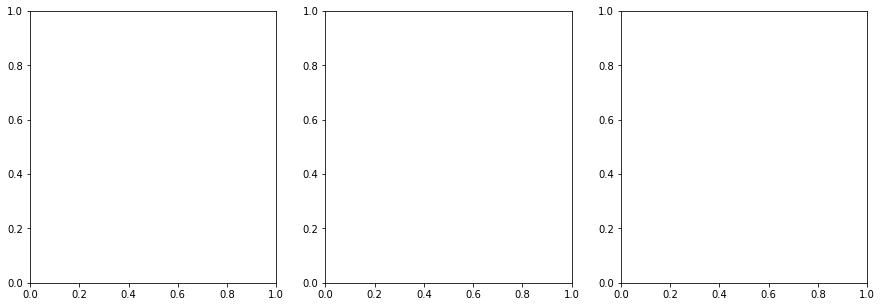

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flatten()

Lists containing tuples for the x-axis and y-axis limits are also created. They are placed in a dictionary where the enzyme module IDs are the `dict` keys.

In [7]:
# Values are formatted as [(xmin, xmax), (ymin, ymax)]
xy_limits = { 
    "PFK":  [(0.67, 0.98), (0.84, 1.01)],
    "HEX1": [(0.65, 1.00), (0.78, 0.89)],
    "PYK":  [(0.60, 1.00), (0.15, 0.88)]}

#### A2.2: Plot steady state lines

The steady state values are plotted as straight lines to visually indicate where the steady state lies.

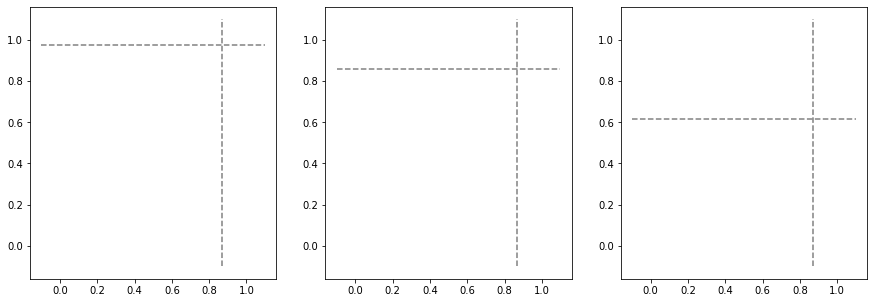

In [8]:
for i, (model, sim) in enumerate(models_and_simulations.items()):
    # Get axes to plot on
    ax = axes[i]
    # Get ID of enzyme module in model
    enzyme_id = enzyme_ids[i]
    # Get MassSolution objects containing steady state values
    conc_sol_ss, flux_sol_ss = sim.find_steady_state(
        model, strategy="simulate", update_values=True, tfinal=1e4)
    
    # Make an aggregate solution for the energy charge
    make_energy_charge_solution(conc_sol_ss)
    # Plot a vertical line at the steady steady value
    ax.plot([conc_sol_ss["energy_charge"]] * 2,
            [-0.1, 1.1],
            color="grey", linestyle="--")
    
    # Make an aggregate solution for the active fraction
    make_active_fraction_solution(model, conc_sol_ss, enzyme_id)
    # Plot a horizontal line at the steady steady value
    ax.plot([-0.1, 1.1],
            [conc_sol_ss["active_fraction"]] * 2,
            color="grey", linestyle="--")
fig

#### A2.3: Plot catalytic potentials for 15% decrease in ATP utilization

The first set of results to plot on the figure are the results obtained from simulating the models with a 15% decrease in ATP utilization. This behavior is mimicked by perturbing the rate constant for ATP use to be 0.85 times its original value. The color "red" will be used to represent these results.

Legends are also created for perturbations and the annotated time points, placed below and above the middle plot, respectively.

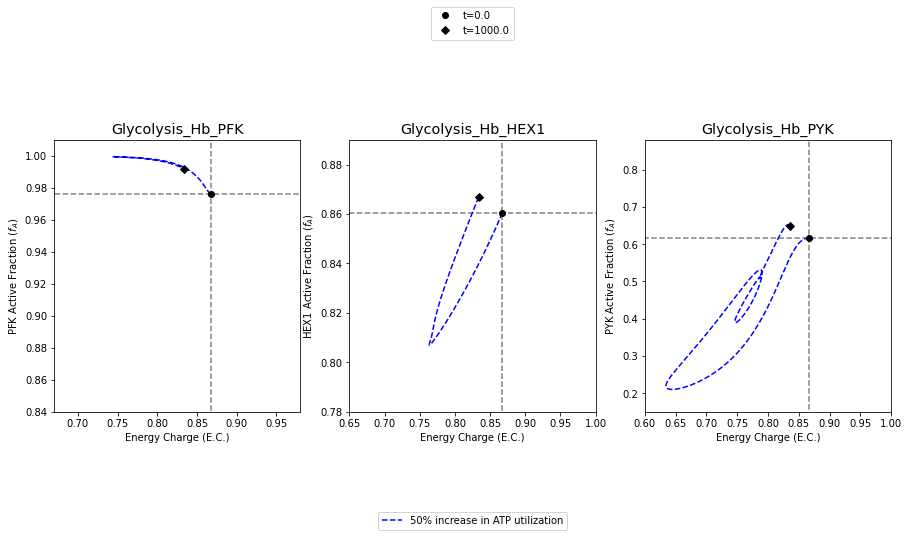

In [9]:
for i, (model, sim) in enumerate(models_and_simulations.items()):
    # Get axes to plot on
    ax = axes[i]
    # Get ID of enzyme module in model
    enzyme_id = enzyme_ids[i]
    # Simulate model with a 50% increase in ATP utilization
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, 1000),
        perturbations={"kf_ATPM": "kf_ATPM * 1.5"});
    
    # Make an aggregate solution for the energy charge
    make_energy_charge_solution(conc_sol)
    
    # Make an aggregate solution for the active fraction
    make_active_fraction_solution(model, conc_sol, enzyme_id)

    # Place legend on middle plot only
    if i == 1:
        legend = ("50% increase in ATP utilization", "lower outside")
        time_points_legend = "upper outside"
    else:
        legend = None
        time_points_legend = None

    # Get x and y axes limits
    xlimits, ylimits = xy_limits[enzyme_id]
    # Make phase portrait
    plot_phase_portrait(
        conc_sol, x="energy_charge", y="active_fraction",
        ax=ax, legend=legend,                  # Axes instance and legend
        xlim=xlimits, ylim=ylimits,            # Axes limits
        xlabel="Energy Charge (E.C.)",         # Axes labels
        ylabel=enzyme_id + " Active Fraction ($f_{A}$)",
        title=(model.id, {"size": "x-large"}), # Title
        linestyle="--", color="blue",          # Line color and style
        annotate_time_points="endpoints",      # Annotate time points
        annotate_time_points_color="black",
        annotate_time_points_legend=time_points_legend,
    ) 
fig 

#### A2.4: Plot catalytic potentials for 50% increase in ATP utilization

The second set of results to plot on the figure are the results obtained from simulating the models with a 50% increase in ATP utilization. This behavior is mimicked by perturbing the rate constant for ATP use to be 1.5 times its original value. The color "blue" will be used to represent these results.

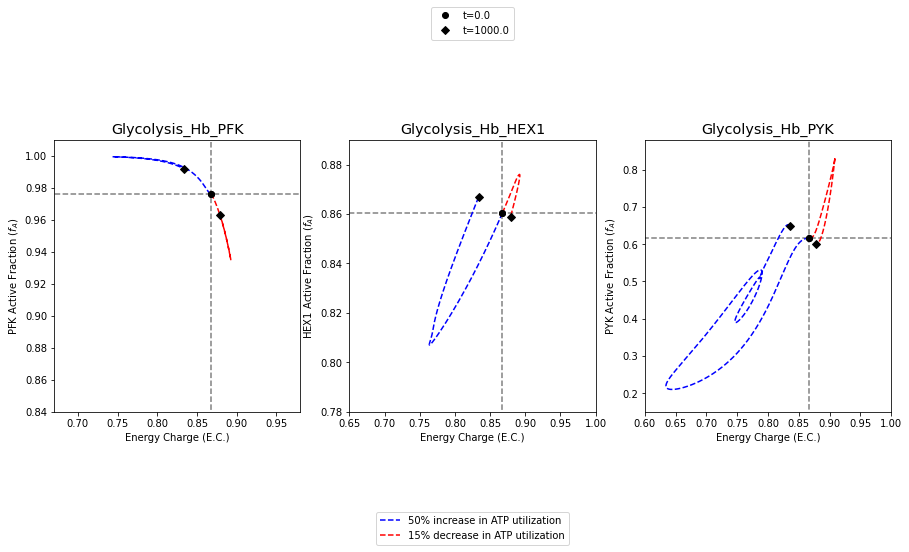

In [10]:
for i, (model, sim) in enumerate(models_and_simulations.items()):
    # Get axes to plot on
    ax = axes[i]
    # Get ID of enzyme module in model
    enzyme_id = enzyme_ids[i]

    # Simulate model with a 50% increase in ATP utilization
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, 1000),
        perturbations={"kf_ATPM": "kf_ATPM * 0.85"});
    
    # Make an aggregate solution for the energy charge
    make_energy_charge_solution(conc_sol)
    
    # Make an aggregate solution for the active fraction
    make_active_fraction_solution(model, conc_sol, enzyme_id)

    # Place legend on middle plot only
    if i == 1:
        legend = ("15% decrease in ATP utilization", "lower outside")
        time_points_legend = "upper outside"
    else:
        legend = None
        time_points_legend = None
    # Get x and y axes limits
    xlimits, ylimits = xy_limits[enzyme_id]
    # Make phase portrait
    plot_phase_portrait(
        conc_sol, x="energy_charge", y="active_fraction",
        ax=ax, legend=legend,                  # Axes instance and legend
        xlim=xlimits, ylim=ylimits,            # Axes limits
        xlabel="Energy Charge (E.C.)",         # Axes labels
        ylabel=enzyme_id + " Active Fraction ($f_{A}$)",
        title=(model.id, {"size": "x-large"}), # Title
        linestyle="--", color="red",           # Line color and style
        annotate_time_points="endpoints",      # Annotate time points
        annotate_time_points_color="black",
        annotate_time_points_legend=time_points_legend,
    ) 
fig 

#### A2.5: Time profile of FDP concentration
The plot of FDP concentration in the upper left quadrant of the plot for the catalytic potential of PYK is created.

First, the inset axes instance is created and the axes tick labels are removed:

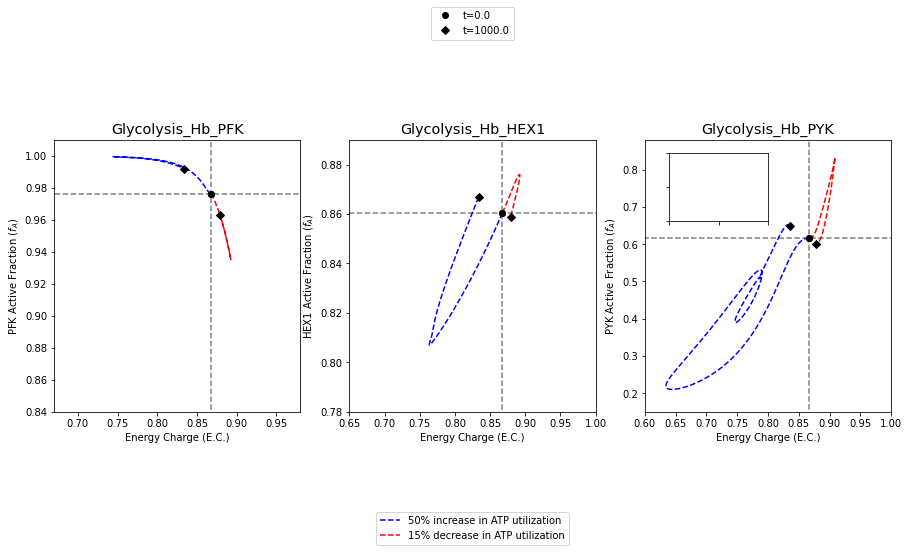

In [11]:
# Get the axes instance
right_ax = axes[-1]
ax_inset = right_ax.inset_axes([0.1, 0.7, 0.4, 0.25])
ax_inset.tick_params(labelbottom=False, labelleft=False)
fig

The model with the PYK enzyme module is simulated with a 15% decrease in ATP utilization, and the results are plotted. 

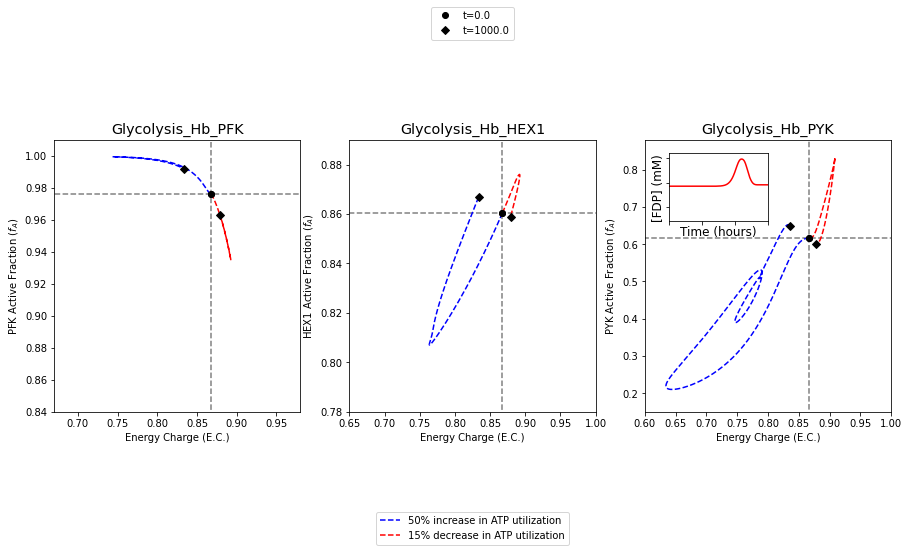

In [12]:
for model, sim in models_and_simulations.items():
    # Only interested in the third model
    if model.id != "Glycolysis_Hb_PYK":
        continue
    # Simulate model with a 50% increase in ATP utilization
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, 1000),
        perturbations={"kf_ATPM": "kf_ATPM * 0.85"});
    
    # Plot FDP time profile
    plot_time_profile(
        conc_sol, observable="fdp_c", ax=ax_inset,
        plot_function="semilogx",
        xlim=(1e-6, 1000), ylim=(0.002, 0.016),
        xlabel=("Time (hours)", {"size": "large"}),
        ylabel=("[FDP] (mM)", {"size": "large"}),
        color="red")
fig

In a similar fashion, the results of simulating the model with a 50% increase in ATP utilization are plotted.

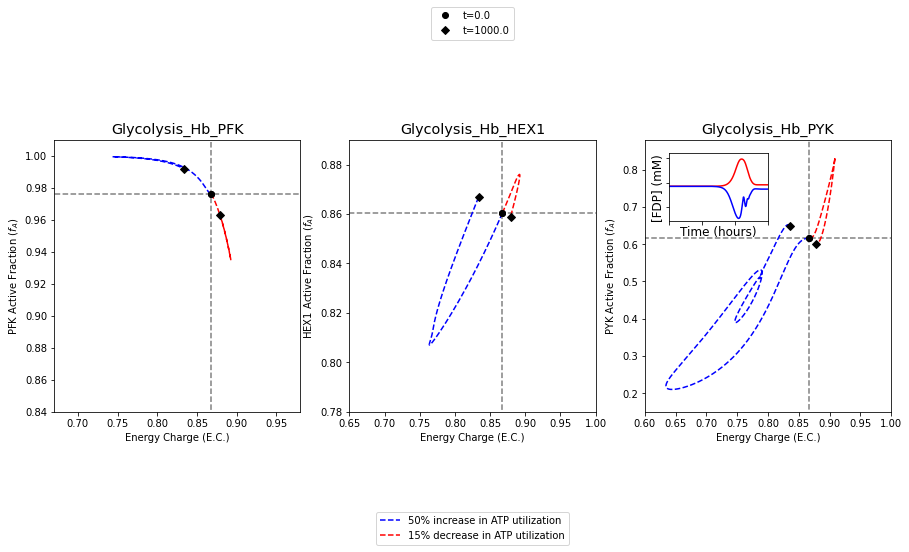

In [13]:
for model, sim in models_and_simulations.items():
    # Only interested in the third model
    if model.id != "Glycolysis_Hb_PYK":
        continue
    # Simulate model with a 50% increase in ATP utilization
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, 1000),
        perturbations={"kf_ATPM": "kf_ATPM * 1.5"});
    
    # Plot FDP time profile
    plot_time_profile(
        conc_sol, observable="fdp_c", ax=ax_inset,
        plot_function="semilogx",
        xlim=(1e-6, 1000), ylim=(0.002, 0.016),
        xlabel=("Time (hours)", {"size": "large"}),
        ylabel=("[FDP] (mM)", {"size": "large"}),
        color="blue")
fig

[Figure 2](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g002) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> has been reproduced.

## Example B: Phase Portraits of Catalytic Potentials and Interplay Among Enzymes

In this example, the three key regulatory kinases of glycolysis are integrated into the glycolytic network as enzyme modules.

Specifically, this notebook example focuses on visualizing the catalytic potentials of enzymes as well as the interplay among enzymes when all three enzyme modules are integrated into the network in order to reproduce [Figure 4](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g004) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite>.

### B1: All in one
The following cell reproduces [Figure 4](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g004) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite>.

Successfully loaded MassModel 'Glycolysis_FKRM' into RoadRunner.


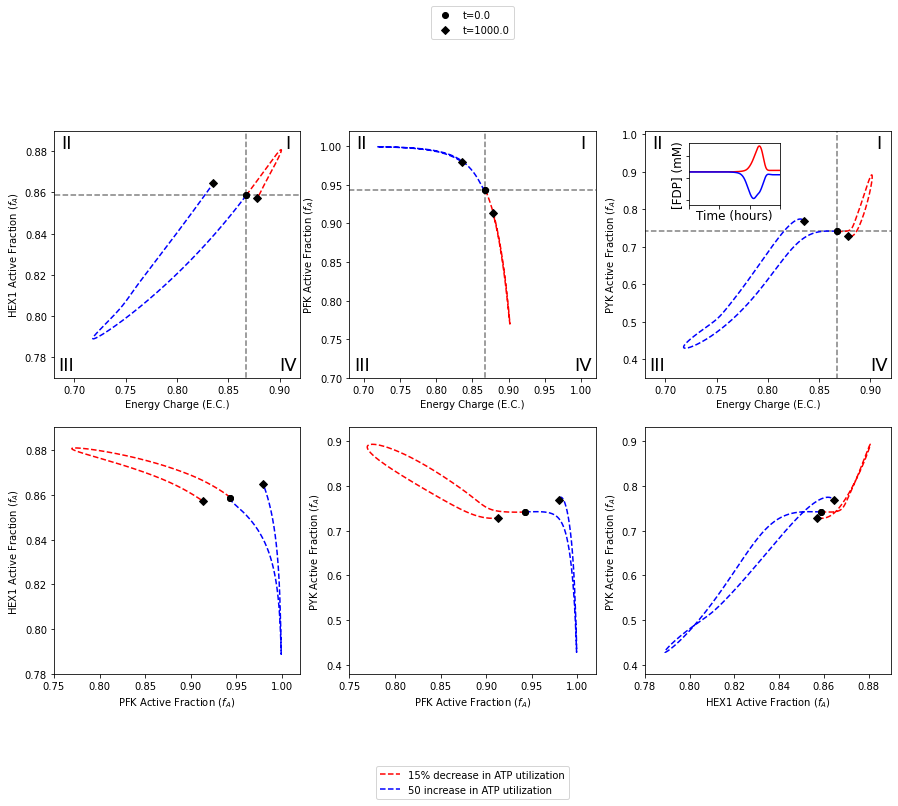

In [14]:
# Load model and simulation
model = create_example_model("Glycolysis_FKRM.json")
simulation = Simulation(model, verbose=True)

# Define perturbations
perturbation_list = [
    {"kf_ATPM": "kf_ATPM * 0.85"},
    {"kf_ATPM": "kf_ATPM * 1.50"}]
# Define colors and legend labels
colors = ["red", "blue"]
labels = ["15% decrease", "50 increase"]

# Define enzyme pairs and axes limits
enzyme_pairs = [("PFK", "HEX1"), ("PFK", "PYK"), ("HEX1", "PYK")]

# Values are formatted as [(xmin, xmax), (ymin, ymax)]
xy_limits = { 
    "HEX1": ((0.68, 0.92), (0.77, 0.89)),
    "PFK":  ((0.68, 1.02), (0.70, 1.02)),
    "PYK":  ((0.68, 0.92), (0.35, 1.01)),
    ("PFK", "HEX1"): ((0.75, 1.02), (0.78, 0.89)),
    ("PFK", "PYK"):  ((0.75, 1.02), (0.38, 0.93)),
    ("HEX1", "PYK"): ((0.78, 0.89), (0.38, 0.93))}

# Define roman numerals and coordinates
roman_num_coords= {"I":   (0.95, 0.95), "II":  (0.05, 0.95),
                   "III": (0.05, 0.05), "IV":  (0.95, 0.05)}

# Define helper functions to make aggregate solutions
def make_energy_charge_solution(conc_sol):
    conc_sol.make_aggregate_solution(
        aggregate_id="energy_charge",
        equation="(atp_c + 0.5 * adp_c) / (atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)

def make_active_fraction_solution(conc_sol, enzyme):
    active = enzyme.enzyme_module_forms_categorized.get_by_id(
        enzyme.id + "_Active")
    conc_sol.make_aggregate_solution(
        aggregate_id=enzyme.id + "_active_fraction",
        equation="({0}) / ({1})".format(
            " + ".join([e.id for e in active.members]), 
            str(strip_time(enzyme.enzyme_concentration_total_equation))),
        variables=enzyme.enzyme_module_forms, update=True)

# Create figure and axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Get the rightmost axes instance on the top row
right_ax = axes[0][-1]
# Create inset axes
ax_inset = right_ax.inset_axes([0.18, 0.7, 0.37, 0.25])
# Remove tick labels
ax_inset.tick_params(labelbottom=False, labelleft=False)

# Simulate to steady state
conc_sol, flux_sol = simulation.find_steady_state(
    model, strategy="simulate", update_values=True, tfinal=1e4)
# Make aggregate solution for energy charge
make_energy_charge_solution(conc_sol)

# Iterate through enzyme modules and axes for the top half of figure
for enzyme, ax in zip(model.enzyme_modules, axes[0]):
    # Make aggregate solutions for the active fraction
    make_active_fraction_solution(conc_sol, enzyme)
    # Plot steady state lines for energy charge and active fraction
    ax.plot([conc_sol["energy_charge"]] * 2,
            [-0.1, 1.1],
            color="grey", linestyle="--")
    ax.plot([-0.1, 1.1],
            [conc_sol[enzyme.id + "_active_fraction"]] * 2,
            color="grey", linestyle="--")
    # Add roman numerals to the top axes.
    for roman_num, coords in roman_num_coords.items():
        ax.text(*coords, roman_num, fontsize=18, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center')

# Iterate through perturbations and colors
for i, (perturbation, color) in enumerate(zip(perturbation_list, colors)):
    # Simulate model with ATP utilization perturbation
    conc_sol, flux_sol = simulation.simulate(
        model, time=(0, 1000), perturbations=perturbation)
    # Make aggregate solution for energy charge
    make_energy_charge_solution(conc_sol)

    # Iterate through enzyme modules and axes for the top half of figure
    for j, (enzyme, ax) in enumerate(zip(model.enzyme_modules, axes[0])):
         # Make aggregate solutions for the active fraction
        make_active_fraction_solution(conc_sol, enzyme)

        # Place time point legend on middle plot only
        if j == 1:
            time_points_legend = "upper outside"
        else:
            time_points_legend = None

        # Make phase portrait of catalytic potential for an enzyme
        plot_phase_portrait(
            conc_sol, x="energy_charge",
            y=enzyme.id + "_active_fraction", ax=ax,
            xlim=xy_limits[enzyme.id][0],          # Axes limits
            ylim=xy_limits[enzyme.id][1],
            xlabel="Energy Charge (E.C.)",         # Axes labels
            ylabel=enzyme.id + " Active Fraction ($f_{A}$)",
            linestyle="--", color=color,           # Line color and style
            annotate_time_points="endpoints",      # Annotate time points
            annotate_time_points_color="black",
            annotate_time_points_legend=time_points_legend)
        
        # Plot time profile of FDP on the inset axes
        if j == 2:
            # Plot FDP time profile
            plot_time_profile(
                conc_sol, observable="fdp_c", ax=ax_inset,
                plot_function="semilogx",
                xlim=(1e-6, 1000), ylim=(0.004, 0.018),
                xlabel=("Time (hours)", {"size": "large"}),
                ylabel=("[FDP] (mM)", {"size": "large"}),
                color=color)

    # Iterate through enzyme pairs and axes for bottom half of figure
    for j, (enzyme_pair, ax) in enumerate(zip(enzyme_pairs, axes[1])):
        # Place legend on middle plot only (PFK vs. PYK)
        if j == 1:
            legend = (labels[i] + " in ATP utilization",
                      "lower outside")
        else:
            legend = None
        # Get the enzyme for the x-axis and for the y-axis
        enz_x, enz_y = enzyme_pair
        plot_phase_portrait(
            conc_sol,
            x=enz_x + "_active_fraction", y=enz_y + "_active_fraction",
            ax=ax, legend=legend,              # Axes instance and legend
            xlim=xy_limits[enzyme_pair][0],    # Axes limits
            ylim=xy_limits[enzyme_pair][1],
            xlabel=enz_x + " Active Fraction ($f_{A}$)", # Axes labels
            ylabel=enz_y + " Active Fraction ($f_{A}$)",
            color=color, linestyle="--",       # Line color and style
            annotate_time_points="endpoints",  # Annotate time points
            annotate_time_points_color="black")

### B2: Steps to Reproduce

In this section, the steps for reproducing [Figure 4](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g004) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> are outlined below in an expanded workflow.

#### B2.1: Setup

The first step is to load the model and ensure it exists in a steady state.

In [15]:
model = create_example_model("Glycolysis_FKRM.json")
simulation = Simulation(model, verbose=True)
simulation.find_steady_state(model, strategy="simulate",
                             update_values=True, tfinal=1e4)

Successfully loaded MassModel 'Glycolysis_FKRM' into RoadRunner.


(<MassSolution Glycolysis_FKRM_ConcSols at 0x7fca8200a530>,
 <MassSolution Glycolysis_FKRM_FluxSols at 0x7fca9bc00e90>)

When the `EnzymeModule` objects were created, the active forms of the enzyme was categorized and placed in a group. This will make creating the solution for the active fraction of the enzyme significantly easier.

In [16]:
for enzyme_module in model.enzyme_modules:
    
    active = enzyme_module.enzyme_module_forms_categorized.get_by_id(
        "_".join((enzyme_module.id, "Active")))
    
    print("Enzyme: " + enzyme_module.id)
    print("Group ID: " + active.id)
    print("# of members: {0}\n".format(len(active.members)))

Enzyme: HEX1
Group ID: HEX1_Active
# of members: 4

Enzyme: PFK
Group ID: PFK_Active
# of members: 15

Enzyme: PYK
Group ID: PYK_Active
# of members: 20



Because aggregate solutions for the adenylate energy charge and enzyme active fractions will need to be created multiple times, smaller "helper" functions are defined to facilate this process.

In [17]:
def make_energy_charge_solution(conc_sol):
    conc_sol.make_aggregate_solution(
        aggregate_id="energy_charge",
        equation="(atp_c + 0.5 * adp_c) / (atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)
    return

def make_active_fraction_solution(conc_sol, enzyme_module):
    # Get active group
    active = enzyme_module.enzyme_module_forms_categorized.get_by_id(
        enzyme_module.id + "_Active")

    # Create string representing sum of active enzyme forms
    active_eq = " + ".join([e.id for e in active.members])

    # Create string representing sum of all enzyme forms
    total_eq  = str(strip_time(
        enzyme_module.enzyme_concentration_total_equation))

    # Make aggregate solution
    conc_sol.make_aggregate_solution(
        aggregate_id=enzyme_module.id + "_active_fraction",
        equation="({0}) / ({1})".format(active_eq, total_eq),
        variables=enzyme_module.enzyme_module_forms, update=True)
    return

The figure and axes instances are created using **matplotlib**. The figure size is set as 15 x 10 to create three square plots in two rows for a total of 6 plots. Each plot will be have a size of 5 x 5.

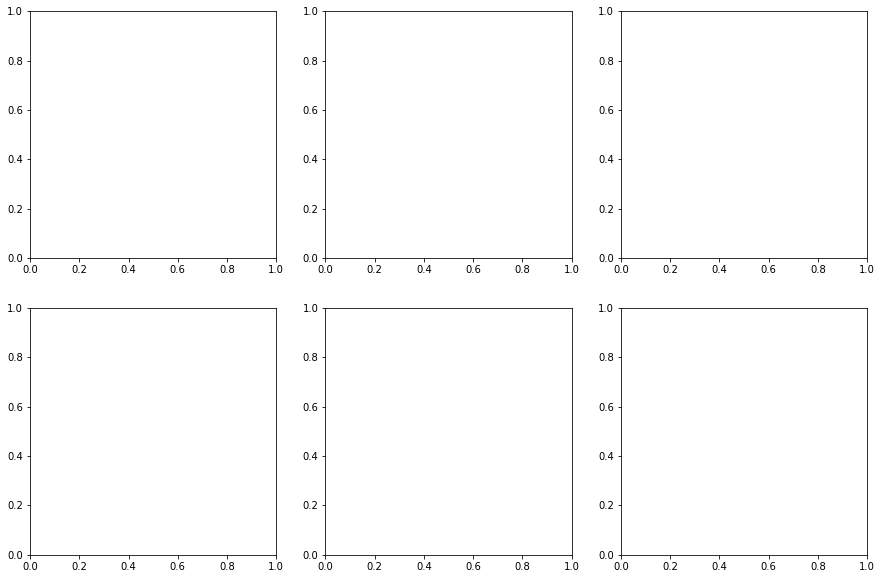

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

#### B2.2: Plot catalytic potential of enzymes
The following section demonstrates the necessary steps for generating the top half of the figure. The top half of the figure contains plots of the catalytic potentials for enzymes as a function of energy charge.

##### B2.2.1: Plot steady state lines
The steady state values are plotted as straight lines to visually indicate where the steady state lies.

In [19]:
# Simulate to steady state
conc_sol_ss, flux_sol_ss = simulation.find_steady_state(
    model, strategy="simulate", update_values=True, tfinal=1e4)
# Make aggregate solutions for energy charge
make_energy_charge_solution(conc_sol_ss)

# Iterate through enzyme modules and axes for the top half of figure
for enzyme_module, ax in zip(model.enzyme_modules, axes[0]):
    # Make aggregate solutions for the active fraction
    make_active_fraction_solution(conc_sol_ss, enzyme_module)
    # Plot steady state lines for energy charge
    ax.plot([conc_sol_ss["energy_charge"]] * 2,
            [-0.1, 1.1],
            color="grey", linestyle="--")
    # Plot steady state lines for active fraction
    ax.plot([-0.1, 1.1],
            [conc_sol_ss[enzyme_module.id + "_active_fraction"]] * 2,
            color="grey", linestyle="--")

##### B2.2.2: Label quadrants with roman numerals

Roman numerals I-IV are added to the quandrants as follows:
* (I) more enzyme in active form and higher energy charge
* (II) more enzyme in active form and lower energy
* (III) more enzyme in inactive form and lower energy charge
* (IV) more enzyme in inactive form and higher energy charge

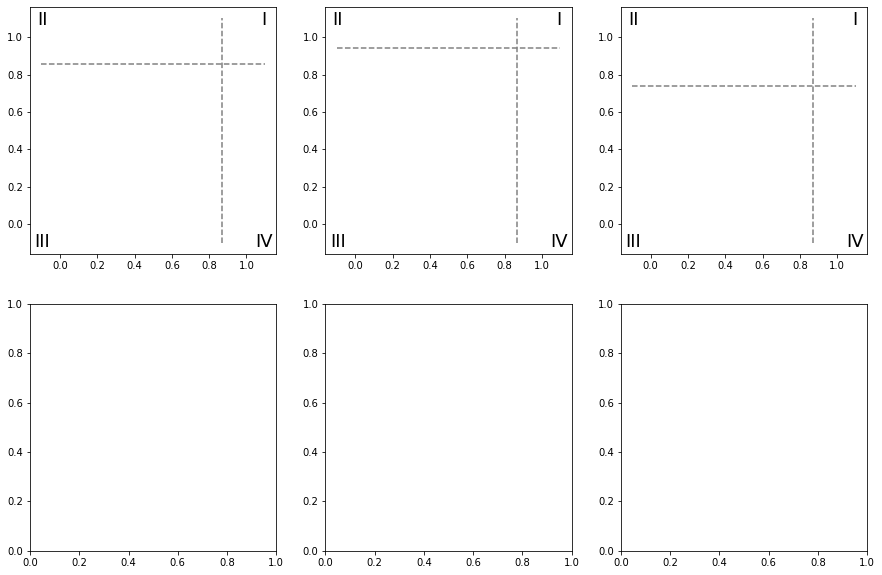

In [20]:
# Define roman numerals and coordinates
roman_num_coords= {
    "I":   (0.95, 0.95),
    "II":  (0.05, 0.95),
    "III": (0.05, 0.05),
    "IV":  (0.95, 0.05)}
# Iterate through each axes
for ax in axes[0]:
    # Add each number to the current axes.
    for roman_num, coords in roman_num_coords.items():
        ax.text(*coords, roman_num, fontsize=18,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
fig

##### B2.2.3: Plot catalytic potentials for ATP utilization perturbations

After plotting the steady state lines and labeling the quadrants, the model is simulated with perturbations to the ATP utilization rate. These perturbations include a 15% decrease in the rate constant for ATP use and a 50% increase in the rate constant for ATP use, represented by the colors "red" and "blue" respectively.

A legend is also created for the annotated time points, placed above the top middle plot (PFK catalytic potential).

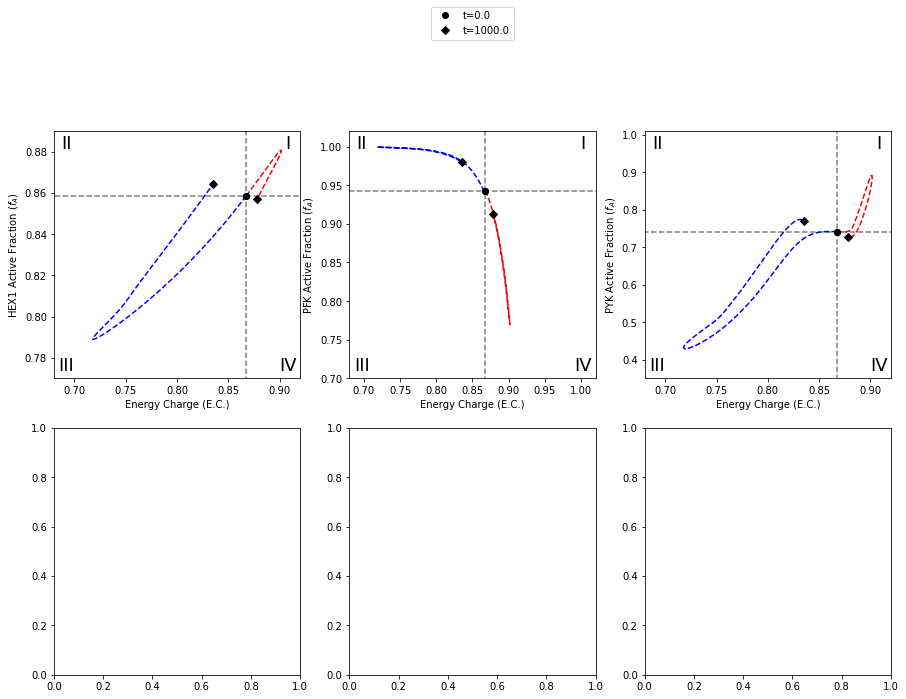

In [21]:
# Values are formatted as [(xmin, xmax), (ymin, ymax)]
xy_limits = { 
    "HEX1": [(0.68, 0.92), (0.77, 0.89)],
    "PFK":  [(0.68, 1.02), (0.70, 1.02)],
    "PYK":  [(0.68, 0.92), (0.35, 1.01)]}

# Iterate through perturbations and colors
perturbation_list = [
    {"kf_ATPM": "kf_ATPM * 0.85"},
    {"kf_ATPM": "kf_ATPM * 1.50"}]
colors = ["red", "blue"]
for perturbation, color in zip(perturbation_list, colors):
    # Simulate model with ATP utilization perturbation
    conc_sol, flux_sol = simulation.simulate(
        model, time=(0, 1000), perturbations=perturbation)
    
    # Make aggregate solutions for energy charge and active fraction
    make_energy_charge_solution(conc_sol)
    
    # Iterate through enzyme modules and axes for the top half of figure
    for enzyme_module, ax in zip(model.enzyme_modules, axes[0]):
        # Make aggregate solutions for the active fraction
        make_active_fraction_solution(conc_sol, enzyme_module)
        
        # Place time point legend on middle plot only (PFK)
        if enzyme_module.id == "PFK":
            time_points_legend = "upper outside"
        else:
            time_points_legend = None

        # Make phase portrait
        plot_phase_portrait(
            conc_sol, x="energy_charge",
            y=enzyme_module.id + "_active_fraction", ax=ax,
            xlim=xy_limits[enzyme_module.id][0],   # Axes limits
            ylim=xy_limits[enzyme_module.id][1],
            xlabel="Energy Charge (E.C.)",         # Axes labels
            ylabel=enzyme_module.id + " Active Fraction ($f_{A}$)",
            linestyle="--", color=color,           # Line color and style
            annotate_time_points="endpoints",      # Annotate time points
            annotate_time_points_color="black",
            annotate_time_points_legend=time_points_legend)
fig

##### B2.2.4: Time profile for FDP concentration

The last step for creating the top half of the figure is to add the time profile of FDP concentration in the 2nd quadrant of the PYK catalytic potential plot.

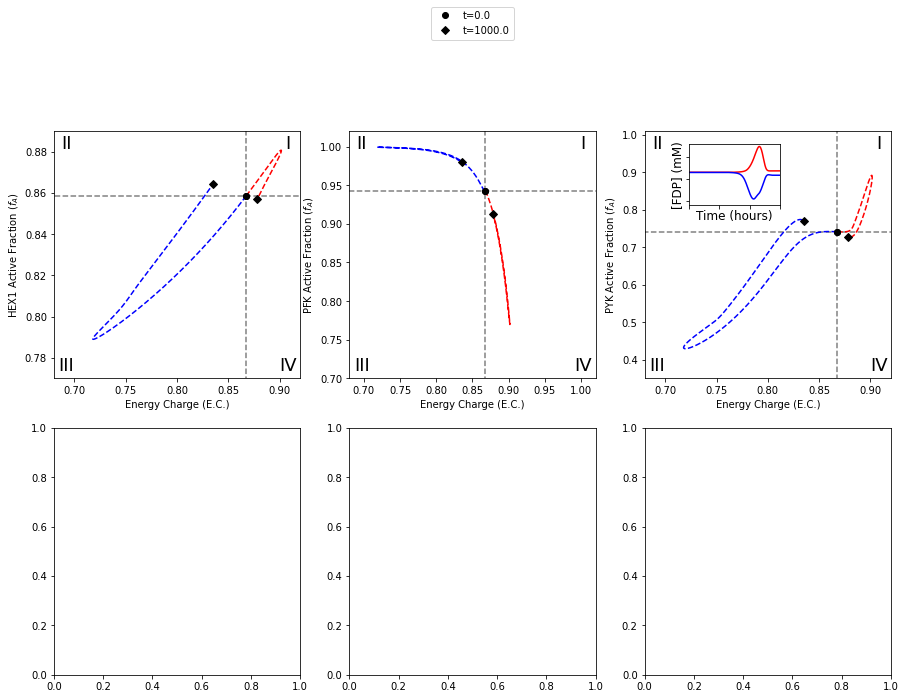

In [22]:
# Get the rightmost axes instance on the top row
right_ax = axes[0][-1]
# Create inset axes
ax_inset = right_ax.inset_axes([0.18, 0.7, 0.37, 0.25])
# Remove tick labels
ax_inset.tick_params(labelbottom=False, labelleft=False)

# Iterate through perturbations and colors
perturbation_list = [
    {"kf_ATPM": "kf_ATPM * 0.85"},
    {"kf_ATPM": "kf_ATPM * 1.50"}]
colors = ["red", "blue"]
for perturbation, color in zip(perturbation_list, colors):
    # Simulate model with ATP utilization perturbation
    conc_sol, flux_sol = simulation.simulate(
        model, time=(0, 1000), perturbations=perturbation)
    
    # Plot FDP time profile
    plot_time_profile(
        conc_sol, observable="fdp_c", ax=ax_inset,
        plot_function="semilogx",
        xlim=(1e-6, 1000), ylim=(0.004, 0.018),
        xlabel=("Time (hours)", {"size": "large"}),
        ylabel=("[FDP] (mM)", {"size": "large"}),
        color=color)
fig

#### B2.3: Plot pairwise relationships of enzyme active fractions
The following section demonstrates the necessary steps for generating the bottom half of the figure. The bottom half of the figure contains plots of the pairwise relationships between the active fractions of two kinases.

A legend is also created for the different simulations performed, placed above the bottom middle plot (PFK vs. PYK active fractions).

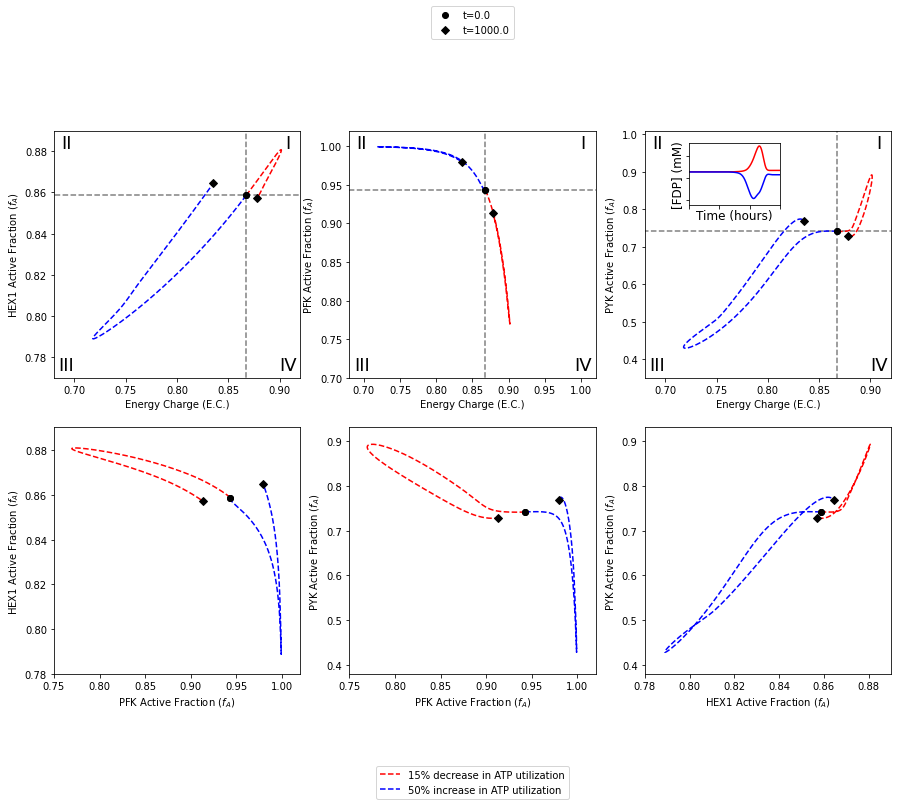

In [23]:
enzyme_pairs = [("PFK", "HEX1"), ("PFK", "PYK"), ("HEX1", "PYK")]
xy_limits = dict(zip(
    enzyme_pairs, [
        ((0.75, 1.02), (0.78, 0.89)), 
        ((0.75, 1.02), (0.38, 0.93)),
        ((0.78, 0.89), (0.38, 0.93)),
    ]
))
labels = ["15% decrease", "50% increase"]
# Iterate through perturbations and colors
for i, (perturbation, color) in enumerate(zip(perturbation_list, colors)):
    # Simulate model with ATP utilization perturbation
    conc_sol, flux_sol = simulation.simulate(
        model, time=(0, 1000), perturbations=perturbation)
    
    # Make aggregate solutions for the active fractions
    for enzyme_module in model.enzyme_modules:
        make_active_fraction_solution(conc_sol, enzyme_module)

    # Iterate through enzyme pairs and axes for bottom half of figure
    for enzyme_pair, ax in zip(enzyme_pairs, axes[1]):
        
        # Place legend on middle plot only (PFK vs. PYK)
        if enzyme_pair == ("PFK", "PYK"):
            legend = (labels[i] + " in ATP utilization",
                      "lower outside")
        else:
            legend = None
        
        # Get the enzyme for the x-axis and for the y-axis
        enz_x, enz_y = enzyme_pair
        plot_phase_portrait(
            conc_sol,
            x=enz_x + "_active_fraction", y=enz_y + "_active_fraction",
            ax=ax, legend=legend,              # Axes instance and legend
            xlim=xy_limits[enzyme_pair][0],    # Axes limits
            ylim=xy_limits[enzyme_pair][1],
            xlabel=enz_x + " Active Fraction ($f_{A}$)", # Axes labels
            ylabel=enz_y + " Active Fraction ($f_{A}$)", 
            color=color, linestyle="--",       # Line color and style
            annotate_time_points="endpoints",  # Annotate time points
            annotate_time_points_color="black")
fig

[Figure 4](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g004) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> has been reproduced.